In [0]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import soundfile as sf
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install soundfile

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
os.getcwd()

'/content'

In [0]:
path = '/content/gdrive/My Drive/data/data'
os.chdir(path)

In [6]:
os.getcwd()

'/content/gdrive/My Drive/data/data'

In [0]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [0]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    data,rate = sf.read(wav_file)
    return rate, data


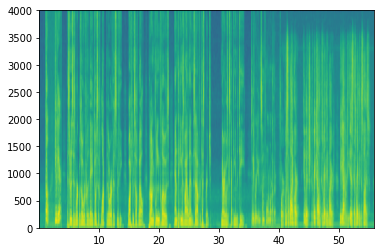

In [9]:
labels = []
file_names = []
samples = []

for direc in os.listdir(path):
    for subdir in os.listdir(path +"/" + direc):
        file = [ f for f in os.listdir(path + '/' + direc + "/" + subdir) if f.endswith('.txt')]
        for f in file:
            with open(path + "/" + direc + "/" + subdir  +'/' +f ,'r') as txtfile:
                data = txtfile.read()
                sentence = data.lower().split('\n')
                for sent in sentence:
                    sent = sent.split(" ",1)
                    if len(sent) == 2:
                        file_names.append(sent[0])
                        sample = graph_spectrogram(path + "/" + direc + "/" + subdir  +'/'+ sent[0] +'.flac')
                        samples.append(sample)
                        labels.append(sent[1])
                    else:
                        continue
                    if(len(samples)) > 500:
                      break
                        

In [10]:
len(labels)

557

In [11]:
len(samples)

557

In [12]:
max_len = 0
for sam in samples:
  if sam.shape[1] > max_len:
    max_len = sam.shape[1]

print(max_len)


5596


In [13]:
labels[2]

'such crimes would have deserved the animadversion of the magistrate but in this promiscuous outrage the innocent were confounded with the guilty and alexandria was impoverished by the loss of a wealthy and industrious colony'

In [14]:
new_samples = []
count = 0
for sam in samples:
  a = np.zeros((101,max_len))
  a[:,:sam.shape[1]] = sam
  new_samples.append(a)
  count +=1

print(count)


557


In [15]:
new_samples = np.array(new_samples)
new_samples = new_samples.reshape(557,101,5596,1)
print(new_samples.shape)




(557, 101, 5596, 1)


In [0]:
max_label = 0
for label in labels:
  if len(label) > max_label:
    max_label = len(label) 



In [17]:
print(max_label)

396


In [0]:
import numpy as np

#%%
# From Baidu ba-dls-deepspeech - https://github.com/baidu-research/ba-dls-deepspeech
# Character map list

char_map_str = """
<SPACE> 0
a 1
b 2
c 3
d 4
e 5
f 6
g 7
h 8
i 9
j 10
k 11
l 12
m 13
n 14
o 15
p 16
q 17
r 18
s 19
t 20
u 21
v 22
w 23
x 24
y 25
z 26
' 27
"""

char_map = {}
index_map = {}

for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch

index_map[0] = ' '


def get_param(Y):
  labels = np.zeros((557,396))

  for idx,label in enumerate(Y):
    new = []
    for word in label.split():
      for c in word:
        if c not in char_map:
          continue
        elif c == "'":
          continue
        else:
          ch = char_map[c]
          new.append(ch)
      if(len(new) < max_label):
        new.append(0)
    while(len(new) < max_label):
      new.append(27)
    labels[idx,:] = np.array(new)

  input_length = np.array([max_label for _ in Y])
  label_length = np.array([max_label for _ in Y])


  return labels , input_length , label_length           

In [19]:
char_map


{"'": 27,
 '<SPACE>': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [0]:
from keras.layers import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length )    
    
        
#%%
class CTC():
    """
    Usage:
        sr_ctc = CTC(enter input_size and output_size)
        sr_ctc.build()
        sr_ctc.m.compile()
        sr_ctc.tm.compile()
    """       
    def __init__(self,
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None
        self.tm = None
                   
    def build(self, 
              conv_filters = 396,
              conv2d_filters = 5,
              conv_size = 5,
              conv_strides = 1,
              act = 'relu',
              rnn_layers = 2,
              LSTM_units = 128,
              drop_out = 0.8):
           
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(conv2d_filters,
                   conv_size,
                   strides = (conv_strides, conv_strides),
                   padding = "same",
                   name = "conv2d1")(i)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Conv2D(conv2d_filters,
                   conv_size,
                   strides = (conv_strides , conv_strides),
                   padding = "same",
                   name = "conv2d2")(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Reshape([101,-1])(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d1')(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d2')(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Dense(396 , activation="softmax", name ="dense")(x)
        x = Reshape([396,-1])(x)
        for _ in range(rnn_layers):          
            x = Bidirectional(LSTM(LSTM_units, 
                                   return_sequences = True))(x)
            x = Dropout(drop_out)(x)
            x = BatchNormalization()(x)
        y_pred = TimeDistributed(Dense(self.output_size, 
                                       activation = 'softmax'))(x)        
        # ctc inputs
        labels = Input(name='the_labels', shape=[None,], dtype='int32')
        input_length = Input(name='input_length', shape=[1], dtype='int32')
        label_length = Input(name='label_length', shape=[1], dtype='int32')    
        # Keras doesn't currently support loss funcs with extra parameters
        # so CTC loss is implemented in a lambda layer
        loss_out = Lambda(ctc_lambda_func, 
                          output_shape=(1,), 
                          name='ctc')([y_pred,
                                        labels,
                                        input_length,
                                        label_length])        
        self.tm = Model(inputs = i,
                        outputs = y_pred)
        self.m = Model(inputs = [i, 
                                 labels, 
                                 input_length, 
                                 label_length], 
                        outputs = loss_out)
        return self.m, self.tm


In [0]:
def ctc(y_true, y_pred):
    return y_pred

In [29]:
sr_ctc = CTC((101,5596,1), 28)
sr_ctc.build()

(<keras.engine.training.Model at 0x7fbc1bcecef0>,
 <keras.engine.training.Model at 0x7fbc1bce4390>)

In [30]:
sr_ctc.m.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 101, 5596, 1) 0                                            
__________________________________________________________________________________________________
conv2d1 (Conv2D)                (None, 101, 5596, 5) 130         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 101, 5596, 5) 20          conv2d1[0][0]                    
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 101, 5596, 5) 0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

In [0]:
sr_ctc.m.compile(loss = ctc, optimizer = 'adam', metrics = ['accuracy'])
sr_ctc.tm.compile(loss = ctc, optimizer = 'adam')


In [0]:
labels_train, input_length, label_length = get_param(Y = labels)
labels_val, input_length_val, label_length_val = get_param(Y = labels)


In [35]:
print(labels_train[0])

[ 1. 18.  4.  5. 14. 20.  0.  9. 14.  0. 20.  8.  5.  0. 16. 18. 15. 19.
  5.  3. 21. 20.  9. 15. 14.  0. 15.  6.  0.  8.  5. 18.  5. 19. 25.  0.
  3. 25. 18.  9. 12.  0.  1. 21. 19. 16.  9.  3.  9. 15. 21. 19. 12. 25.
  0. 15. 16.  5. 14.  5.  4.  0.  8.  9. 19.  0. 18.  5.  9.  7. 14.  0.
  2. 25.  0. 15. 16. 16. 18.  5. 19. 19.  9. 14.  7.  0. 20.  8.  5.  0.
 14. 15. 22.  1. 20.  9.  1. 14. 19.  0. 20.  8.  5.  0. 13. 15. 19. 20.
  0.  9. 14. 14. 15.  3.  5. 14. 20.  0.  1. 14.  4.  0.  8.  1. 18. 13.
 12.  5. 19. 19.  0. 15.  6.  0. 20.  8.  5.  0. 19.  5.  3. 20.  1. 18.
  9.  5. 19.  0. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27.
 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27.
 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27.
 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27.
 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27.
 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27

In [36]:
print(type(labels_train[1]))
print("labels" ,labels_train.shape ," ",input_length.shape ," ", label_length.shape)

<class 'numpy.ndarray'>
labels (557, 396)   (557,)   (557,)


In [37]:
 history = sr_ctc.m.fit([new_samples, 
                            labels_train, 
                            input_length, 
                            label_length], 
                       np.zeros([len(labels_train)]), 
                       batch_size = 10, 
                       epochs = 20, 
                       validation_data = ([new_samples, 
                                           labels_val, 
                                           input_length_val, 
                                           label_length_val],
                                          np.zeros([len(labels_val)])), 
                      #  callbacks = [checkpointer], 
                       verbose = 1
                      #  , shuffle = True
                       )

Train on 557 samples, validate on 557 samples
Epoch 1/20
 90/557 [===>..........................] - ETA: 15:07 - loss: 1046.1497 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored